## Reconstruction parcimonieuse


On s'intéresse au problème

$$\hspace{5cm} (\mathcal{P})\quad \min_{x\in \mathbb{R}^n}f(x) = \frac{1}{2}\Vert H x-y \Vert_W^2+\lambda \Vert x \Vert_1 $$

avec $y\in \mathbb{R}^m$ une observation du signal à reconstruire, $H\in \mathcal{M}_{m,n}(\mathbb{R})$, $W\in \mathcal{M}_{m}(\mathbb{R})$ symétrique définie positive. La matrice $W$ introduit une pondération sur les composantes du résidu.

**Question 1 :** Justifier la convexité de la fonctionnelle et donner un sous-gradient.


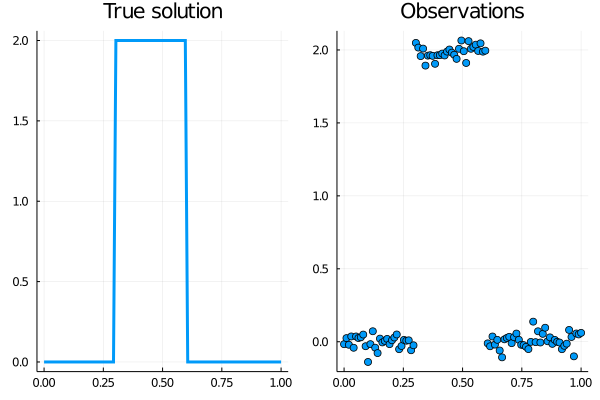

In [1]:
#using Pkg 
#Pkg.add("Plots")
using Plots,LinearAlgebra

# Construction du problème #
############################

# solution à reconstruire 
##########################
dx=0.01;

n=Int(1/dx);#+1;
px=LinRange(0.,1.,n);
xt=zeros(n,1);

for i = 1:n
    if (px[i] > 0.3 && px[i]< 0.6)
        xt[i] = 2;         
    end
end


#observations
#############
nobs=1;
m=Int(floor(n/nobs));
var_obs=0.05;
sigmaW=ones(m,1)+2.0*rand(Float64,(m,1));

H=zeros(m,n);
py=zeros(m,1);
W=zeros(m,m);
for i=1:m
   H[i,(i-1)*nobs+1]=1;
   py[i]=px[(i-1)*nobs+1]; 
   W[i,i]=sigmaW[i];
end    
y=H*xt+var_obs*randn(Float64,(m,1));


p1=plot(px,xt,title="True solution",label=["xt"],lw=3);
p2=scatter(py,y,title="Observations",lw=3);
plot(p1,p2,layout=(1,2),legend=false)

**Question 2 :** Proposer le calcul de l'évaluation de f et d'un sous-gradient de f

In [2]:
# Fonction évaluant f en x
function evalf(x,y,H,W,lambda) 
    # Insérer votre code
    return 1/2*(H*x-y)'*W*(H*x-y) .+ lambda*norm(x,1) 
    # Fin insérer code
end

# Fonction évaluant un sous-gradient de f en x
function subgradf(x,y,H,W,lambda) 
    # Insérer votre code
   return H'*W*(H*x - y)+lambda*sign.(x)
    # Fin insérer code
end

subgradf (generic function with 1 method)

**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Vous implanterez les trois stratégies de pas vues en cours. Vous afficherez les courbes de convergence de $f_{best}^k$. 

**Question 4 :** Quelle influence a le paramètre $\lambda$ sur la convergence de l'algorithme et la qualité de la soltuion optimisée ?

In [ ]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
xbest=x;
i = 0;
fbest =1000000; # $f_{best}^0$
histo =[];# Suite des itérés f_{best}^k

lambda=1e-2;

pas=10^-2;
itermax=500;

xp=x;
while i < itermax
    i = i + 1;
    # Insérer votre code
    x = xbest
    xbest = x- pas*subgradf(x,y,H,W,lambda)
    fbest = evalf(xbest,y,H,W,lambda)
    # Fin insérer code
    
    # Stockage
    append!( histo, fbest)
end
#histo
#Affichage des courbes de convergence
plotly();
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

In [ ]:
x=[xt,xbest];

plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

**Question 5 :** On pose $h(x)=\lambda \Vert x\Vert_1$ et $g(x)=\frac{1}{2}\Vert Hx-y\Vert_W^2$. Donner une expression analytique de la fonction proximale de h et implanter cette fonction. Implanter la fonction $g$ ainsi que son gradient.


In [3]:
# Evaluation de prox_h
function proxh(x,lambda) 
# Insérer votre code
    n = length(x);
    result = zeros(n,1);
    for i = 1:n
        if (x[i] >= lambda)
            result[i] = x[i] -lambda;
        elseif(x[i] <= -lambda)
            result[i] = x[i] +lambda;
        end
    end
    return result
# Fin insérer code
end

#Evaluation de g
function evalg(x,y,H,W)
# Insérer votre code
    return 1/2*(H*x-y)'*W*(H*x-y)
# Fin insérer code
end    


#Evaluation du gradient de g
function gradg(x,y,H,W)
# Insérer votre code
   return H'*W*(H*x-y)
# Fin insérer code
end    

gradg (generic function with 1 method)

**Question 6 :** Résoudre le problème par la méthode du gradient proximal avec recherche linéaire pour le pas. Vous implanterez en prémabule la fonction de recherche linéaire.

In [10]:
# Fonction calculant le pas par recherche linéaire
# Insérer votre code
function pas_rech_lin(x,y,H,W,alpha0,beta)
    alpha = alpha0
    a(t,z) = (t-proxh(t-z*gradg(t,y,H,W),z))/z
    while(evalg(x-alpha*a(x,alpha),y,H,W)[1,1]> evalg(x,y,H,W)[1,1]-(alpha*gradg(x,y,H,W)'*a(x,alpha))[1,1]+alpha/2*norm(a(x,alpha))^2)
        alpha = beta*alpha
    end
    return alpha
end
# Fin insérer code

pas_rech_lin (generic function with 1 method)

In [21]:
#Initialisation
x = zeros(n,1);
xbest=x;
i = 0;
fbest =1000000; # $f_{best}^0$
histo =[];# Suite des itérés f_{best}^k 

lambda0=100;
itermax=500;
beta=0.5;
xp=x;

alpha = lambda0

while i < itermax
    i = i + 1;
    # Insérer votre code
    x = xbest
    alpha = pas_rech_lin(x,y,H,W,alpha,beta)
    xbest = proxh(x- alpha*gradg(x,y,H,W),alpha)
    fbest = evalg(xbest,y,H,W)
    # Fin insérer code
    
    # Stockage
    append!( histo, fbest)
end
#histo
#Affichage des courbes de convergence
plotly();
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

<!DOCTYPE html>
 
 
 Plots.jl

In [22]:
x=[xt,xbest];

plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

<!DOCTYPE html>
 
 
 Plots.jl

**Question 7 :** Evaluez la sensisibilité de l'algorithme aux différents paramètres : $\lambda_0$, $\beta$, itermax.  